Работа с .npy форматом, загрузка 

In [2]:
!python3 test.py

In [3]:
from dataloader import SVGDataset
import torchvision.transforms as T
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch
import math

def set_range(X):
    return 1. - X

SetRange = T.Lambda(set_range)  # convert [0, 1] -> [0, 1]
transform = T.Compose([SetRange])
dataset = SVGDataset("root", 64, 'eng', 52, 51, 12, transform, 'train')

#class_data = dataset[0]['seq_len']  # чтобы обратиться по ключу надо взять 0 индекс
dataloader = data.DataLoader(dataset, 4, shuffle=('train' == 'train'), num_workers=0)  # торчовская функция 

for epoch in range(0, 1):
    for idx, data in enumerate(dataloader):
        # Вывод всех ключей и их форм
        for key, value in data.items():
            print(f"Key: {key}, Shape: {value.shape if torch.is_tensor(value) else 'Not a tensor'}")
        print("------")

Finished loading train paths, number: 8


FileNotFoundError: [Errno 2] No such file or directory: 'root/eng/train/00/rendered_64_italic_.npy'

In [147]:
import torch
#print(data['sequence'])
#print(data['sequence'].shape)
input_sequence = data['sequence']
print(input_sequence.shape)
input_pts_aux = data['pts_aux']
def numericalize(cmd, n=128):
    """NOTE: shall only be called after normalization"""
    # assert np.max(cmd.origin) <= 1.0 and np.min(cmd.origin) >= -1.0 
    cmd = (cmd / 30 * n).round().clip(min=0, max=n-1).int()
    return cmd
arg_quant = numericalize(input_sequence[:, :, :, 4:])
cmd_cls = torch.argmax(input_sequence[:, :, :, :4], dim=-1).unsqueeze(-1)
input_sequence = torch.cat([cmd_cls, arg_quant], dim=-1)

print(input_pts_aux[0][0][0])

torch.Size([4, 52, 51, 12])
tensor([11.7188,  6.0938, 11.7188,  6.0938, 11.7188,  6.0938])


In [148]:
input_image = data['rendered']
ref_cls = torch.randint(0, 52, (1, 4))
trg_cls = torch.tensor([[0]]) #torch.randint(0, 52, (1, 1))

"""
selected_cls = trg_cls
selected_cls_ = selected_cls.unsqueeze(2)
selected_cls_ = selected_cls_.unsqueeze(3)
print(selected_cls_)
selected_cls_ = selected_cls_.expand(1, 4, 64, 64)
selected_img = torch.gather(input_image, 1, selected_cls_)
print(selected_img[0][0][0])
"""

def select_imgs(images_of_onefont, selected_cls):
    # given selected char classes, return selected imgs
    # images_of_onefont: [bs, 52, opts.img_size, opts.img_size]
    # selected_cls: [bs, nshot]
    nums = selected_cls.size(1)
    selected_cls_ = selected_cls.unsqueeze(2)
    selected_cls_ = selected_cls_.unsqueeze(3)
    selected_cls_ = selected_cls_.expand(images_of_onefont.size(0), nums, 64, 64)         
    selected_img = torch.gather(images_of_onefont, 1, selected_cls_)
    return selected_img

ref_img = select_imgs(input_image, ref_cls)
trg_img = select_imgs(input_image, trg_cls)


In [149]:

"""
def select_seqs(seqs_of_onefont, selected_cls, opts, seq_dim):

    nums = selected_cls.size(1)
    selected_cls_ = selected_cls.unsqueeze(2)
    selected_cls_ = selected_cls_.unsqueeze(3)
    selected_cls_ = selected_cls_.expand(seqs_of_onefont.size(0), nums, opts.max_seq_len, seq_dim) 
    selected_seqs = torch.gather(seqs_of_onefont, 1, selected_cls_)
    return selected_seqs
"""

def select_seqs(seqs_of_onefont, selected_cls, n):
    nums = selected_cls.size(1)
    selected_cls_ = selected_cls.unsqueeze(2)
    selected_cls_ = selected_cls_.unsqueeze(3)
    selected_cls_ = selected_cls_.expand(seqs_of_onefont.size(0), nums, 51, n) 
    selected_seqs = torch.gather(seqs_of_onefont, 1, selected_cls_)
    return selected_seqs

print(select_seqs(input_sequence, trg_cls, 9))
print(select_seqs(input_sequence, trg_cls, 9).shape)



tensor([[[[ 1, 50, 25,  ...,  0, 50, 25],
          [ 2, 50, 25,  ...,  0, 53, 25],
          [ 2, 53, 25,  ...,  0, 61, 97],
          ...,
          [ 0,  0,  0,  ...,  0,  0,  0],
          [ 0,  0,  0,  ...,  0,  0,  0],
          [ 0,  0,  0,  ...,  0,  0,  0]]],


        [[[ 1, 40, 25,  ...,  0, 40, 25],
          [ 2, 40, 25,  ...,  0, 63, 25],
          [ 2, 63, 25,  ...,  0, 82, 97],
          ...,
          [ 0,  0,  0,  ...,  0,  0,  0],
          [ 0,  0,  0,  ...,  0,  0,  0],
          [ 0,  0,  0,  ...,  0,  0,  0]]],


        [[[ 1, 50, 24,  ...,  0, 50, 24],
          [ 2, 50, 24,  ...,  0, 53, 24],
          [ 2, 53, 24,  ...,  0, 80, 97],
          ...,
          [ 0,  0,  0,  ...,  0,  0,  0],
          [ 0,  0,  0,  ...,  0,  0,  0],
          [ 0,  0,  0,  ...,  0,  0,  0]]],


        [[[ 1, 50, 25,  ...,  0, 50, 25],
          [ 2, 50, 25,  ...,  0, 52, 25],
          [ 2, 52, 25,  ...,  0, 80, 97],
          ...,
          [ 0,  0,  0,  ...,  0,  0,  0],
    

In [150]:
trg_seq = select_seqs(input_sequence, trg_cls, 9) 
trg_seq = trg_seq.squeeze(1)

ref_seq = select_seqs(input_sequence, ref_cls, 9) 
#print(trg_seq)
print(ref_seq[0][0])

tensor([[ 1, 42, 41,  0,  0,  0,  0, 42, 41],
        [ 2, 42, 41,  0,  0,  0,  0, 44, 41],
        [ 2, 44, 41,  0,  0,  0,  0, 49, 77],
        [ 2, 49, 77,  0,  0,  0,  0, 51, 91],
        [ 2, 51, 91,  0,  0,  0,  0, 51, 91],
        [ 3, 51, 91, 52, 87, 52, 81, 53, 77],
        [ 2, 53, 77,  0,  0,  0,  0, 58, 41],
        [ 2, 58, 41,  0,  0,  0,  0, 60, 41],
        [ 2, 60, 41,  0,  0,  0,  0, 52, 97],
        [ 2, 52, 97,  0,  0,  0,  0, 49, 97],
        [ 2, 49, 97,  0,  0,  0,  0, 42, 41],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  

In [151]:
trg_pts_aux = select_seqs(input_pts_aux, trg_cls, 6)
trg_pts_aux = trg_pts_aux.squeeze(1)
print(trg_pts_aux)
print(trg_pts_aux.shape)

tensor([[[11.7188,  6.0938, 11.7188,  6.0938, 11.7188,  6.0938],
         [11.9531,  6.0938, 12.1875,  6.0938, 12.4219,  6.0938],
         [13.0078, 10.1953, 13.3594, 14.2969, 13.7109, 18.3984],
         ...,
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000]],

        [[ 9.3750,  6.0938,  9.3750,  6.0938,  9.3750,  6.0938],
         [10.6641,  6.0938, 11.9531,  6.0938, 13.2422,  6.0938],
         [15.7031, 10.1953, 16.8750, 14.2969, 18.0469, 18.3984],
         ...,
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000]],

        [[11.7188,  5.6250, 11.7188,  5.6250, 11.7188,  5.6250],
         [11.8359,  5.6250, 11.9531,  5.6250, 12.0703,  5.6250],
         [13.8281,  9.8438, 15.4688, 14.0625, 17.1094, 18.

In [152]:
trg_chat_onehot = F.one_hot(trg_cls, num_classes = 52).squeeze(dim = 1)

In [153]:
trg_seq = select_seqs(input_sequence, trg_cls, 9) 
trg_seq = trg_seq.squeeze(1)
trg_seq_gt = trg_seq.clone().detach()
trg_seq_gt = torch.cat((trg_seq_gt[:, :, :1], trg_seq_gt[:, :, 3:]), -1)

trg_seq = trg_seq.transpose(0, 1)

trg_seq_shifted = F.pad(trg_seq, (0, 0, 0, 0, 1, 0))[:-1, :, :]
print(trg_seq_shifted)
print(trg_seq_shifted.shape)

tensor([[[ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  0,  0]],

        [[ 1, 50, 25,  ...,  0, 50, 25],
         [ 1, 40, 25,  ...,  0, 40, 25],
         [ 1, 50, 24,  ...,  0, 50, 24],
         [ 1, 50, 25,  ...,  0, 50, 25]],

        [[ 2, 50, 25,  ...,  0, 53, 25],
         [ 2, 40, 25,  ...,  0, 63, 25],
         [ 2, 50, 24,  ...,  0, 53, 24],
         [ 2, 50, 25,  ...,  0, 52, 25]],

        ...,

        [[ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  0,  0]],

        [[ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  0,  0]],

        [[ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  

In [154]:
print(trg_seq)

tensor([[[ 1, 50, 25,  ...,  0, 50, 25],
         [ 1, 40, 25,  ...,  0, 40, 25],
         [ 1, 50, 24,  ...,  0, 50, 24],
         [ 1, 50, 25,  ...,  0, 50, 25]],

        [[ 2, 50, 25,  ...,  0, 53, 25],
         [ 2, 40, 25,  ...,  0, 63, 25],
         [ 2, 50, 24,  ...,  0, 53, 24],
         [ 2, 50, 25,  ...,  0, 52, 25]],

        [[ 2, 53, 25,  ...,  0, 61, 97],
         [ 2, 63, 25,  ...,  0, 82, 97],
         [ 2, 53, 24,  ...,  0, 80, 97],
         [ 2, 52, 25,  ...,  0, 80, 97]],

        ...,

        [[ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  0,  0]],

        [[ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  0,  0]],

        [[ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  

In [155]:
input_seqlen = data['seq_len']

#input_seqlen = input_seqlen + 1
print(input_seqlen)

def select_seqlens(seqlens_of_onefont, selected_cls):

    nums = selected_cls.size(1)
    selected_cls_ = selected_cls.unsqueeze(2)
    selected_cls_ = selected_cls_.expand(seqlens_of_onefont.size(0), nums, 1)     # 64, nums, 1    
    selected_seqlens = torch.gather(seqlens_of_onefont, 1, selected_cls_)
    return selected_seqlens

ref_seqlen = select_seqlens(input_seqlen, ref_cls)
ref_seqlen_cat = ref_seqlen.view(ref_seqlen.size(0) * ref_seqlen.size(1), ref_seqlen.size(2))
#print(ref_seqlen_cat)

tensor([[[16],
         [24],
         [17],
         [14],
         [13],
         [11],
         [21],
         [13],
         [ 5],
         [ 9],
         [14],
         [ 7],
         [21],
         [15],
         [14],
         [16],
         [21],
         [19],
         [19],
         [ 9],
         [11],
         [11],
         [21],
         [15],
         [11],
         [11],
         [24],
         [18],
         [17],
         [18],
         [20],
         [17],
         [24],
         [13],
         [10],
         [14],
         [14],
         [ 5],
         [20],
         [13],
         [14],
         [18],
         [18],
         [11],
         [19],
         [17],
         [13],
         [11],
         [23],
         [15],
         [16],
         [11]],

        [[14],
         [21],
         [11],
         [12],
         [13],
         [11],
         [15],
         [13],
         [ 5],
         [ 9],
         [14],
         [ 7],
         [19],
         [15],
        

In [156]:
def select_seqlens(seqlens_of_onefont, selected_cls):

    nums = selected_cls.size(1)
    selected_cls_ = selected_cls.unsqueeze(2)
    selected_cls_ = selected_cls_.expand(seqlens_of_onefont.size(0), nums, 1)     # 64, nums, 1    
    selected_seqlens = torch.gather(seqlens_of_onefont, 1, selected_cls_)
    return selected_seqlens

trg_seqlen = select_seqlens(input_seqlen, trg_cls)
print(trg_seqlen)

tensor([[[16]],

        [[14]],

        [[13]],

        [[13]]])


In [157]:
ref_img = select_imgs(input_image, ref_cls)
trg_img

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
    

In [158]:
"""
print(ref_pad_mask)
"""
#ref_img # [bs, nshot, 64, 64]
#trg_img # [bs, 1, 64, 64]


# dim = 9, 1 command + 8 на точки
#ref_seq # [bs, nshot, max_seq_len, dim]
#ref_seq_cat # [max_seq_len, bs * nshot, dim]

#trg_seq # [max_seq_len, bs, dim]
#trg_seq_gt # [bs, max_seq_len, 7] dim - 2 (начальная точка = конечной предыдущей)
#trg_seq_shifted # [max_seq_len, bs, dim]
#trg_pts_aux # [bs, max_seq_len, 6] вспомогательные точки


#trg_chat_onehot # [bs, onehot]
#trg_cls # [bs, number_char] номера для trg
#trg_seqlen # вектор длин trg

# 0 - EOS, 1 - MOVE, 2 - LINE, 3 - CIRCLE 


'\nprint(ref_pad_mask)\n'

In [159]:
print(trg_seq)
print(trg_seq_gt)


tensor([[[ 1, 50, 25,  ...,  0, 50, 25],
         [ 1, 40, 25,  ...,  0, 40, 25],
         [ 1, 50, 24,  ...,  0, 50, 24],
         [ 1, 50, 25,  ...,  0, 50, 25]],

        [[ 2, 50, 25,  ...,  0, 53, 25],
         [ 2, 40, 25,  ...,  0, 63, 25],
         [ 2, 50, 24,  ...,  0, 53, 24],
         [ 2, 50, 25,  ...,  0, 52, 25]],

        [[ 2, 53, 25,  ...,  0, 61, 97],
         [ 2, 63, 25,  ...,  0, 82, 97],
         [ 2, 53, 24,  ...,  0, 80, 97],
         [ 2, 52, 25,  ...,  0, 80, 97]],

        ...,

        [[ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  0,  0]],

        [[ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  0,  0]],

        [[ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  

Енкодер PNG

In [160]:
ref_img

img_size = 64 
input_nc = 4
ngf = 16

n_downsampling = int(math.log(img_size, 2)) #  количество слоев свертки 
ks_list = [5] * (n_downsampling - n_downsampling // 3) + [3] * (n_downsampling // 3) # размер ядра для каждого слоя
stride_list = [2] * n_downsampling # страйд для каждого слоя 

chn_mult = []
for i in range(n_downsampling):
    chn_mult.append(2 ** (i + 1)) # число каналов на каждом слое

encoder = [nn.Conv2d(input_nc, ngf, kernel_size=7, padding=7 // 2, bias=True, padding_mode='replicate'),
            nn.LayerNorm([ngf, 2 ** n_downsampling, 2 ** n_downsampling]),
            nn.ReLU(True)]

for i in range(n_downsampling):  # add downsampling layers
    if i == 0:
        chn_prev = ngf
    else:
        chn_prev = ngf * chn_mult[i - 1]
    chn_next = ngf * chn_mult[i]

    encoder += [nn.Conv2d(chn_prev, chn_next, kernel_size=ks_list[i], stride=stride_list[i], padding=ks_list[i] // 2, padding_mode='replicate'),
                nn.LayerNorm([chn_next, 2 ** (n_downsampling - 1 - i), 2 ** (n_downsampling - 1 - i)]),
                nn.ReLU(True)]

encode = nn.Sequential(*encoder)
flatten = nn.Flatten(encode) # превращение в одномерный 


print(flatten)

Flatten(
  start_dim=Sequential(
    (0): Conv2d(4, 16, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), padding_mode=replicate)
    (1): LayerNorm((16, 64, 64), eps=1e-05, elementwise_affine=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), padding_mode=replicate)
    (4): LayerNorm((32, 32, 32), eps=1e-05, elementwise_affine=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), padding_mode=replicate)
    (7): LayerNorm((64, 16, 16), eps=1e-05, elementwise_affine=True)
    (8): ReLU(inplace=True)
    (9): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), padding_mode=replicate)
    (10): LayerNorm((128, 8, 8), eps=1e-05, elementwise_affine=True)
    (11): ReLU(inplace=True)
    (12): Conv2d(128, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), padding_mode=replicate)
    (13): LayerNorm((256, 4, 4), eps=1e-05, elementwise_affine=True)
    (14): R

Encoder SEQ

In [161]:
import torch

input_tensor = torch.randn(1, 52, 64, 64)
target_size = [52, 52, 64, 64]
expanded_tensor = input_tensor.expand(52,-1,-1,-1)
print("Размер расширенного тензора:", expanded_tensor.size())   

Размер расширенного тензора: torch.Size([52, 52, 64, 64])


In [162]:
cmd_logits = torch.zeros(1, 51, 4)
for i in range(16):
    random_index = torch.randint(0, 4, (1,)).item()  # Случайный индекс от 0 до 3
    cmd_logits[0, i, random_index] = 1

cmd_args_mask =  torch.Tensor([[0, 0, 0., 0., 0., 0., 0., 0.],
                                       [1, 1, 0., 0., 0., 0., 1., 1.],
                                       [1, 1, 0., 0., 0., 0., 1., 1.],
                                       [1, 1, 1., 1., 1., 1., 1., 1.]])
tgt_commands = trg_seq[:,:,:1].transpose(0,1)
tgt_commands_onehot = F.one_hot(tgt_commands, 4)
args_mask = torch.matmul(tgt_commands_onehot.float(), cmd_args_mask).squeeze()
a = F.log_softmax(cmd_logits, -1)

loss_cmd = torch.sum(- tgt_commands_onehot.squeeze() * F.log_softmax(cmd_logits, -1), -1)
print(loss_cmd)


tensor([[1.7437, 1.7437, 1.7437, 1.7437, 0.7437, 1.7437, 1.7437, 1.7437, 1.7437,
         0.7437, 1.7437, 1.7437, 1.7437, 0.7437, 0.7437, 1.7437, 1.3863, 1.3863,
         1.3863, 1.3863, 1.3863, 1.3863, 1.3863, 1.3863, 1.3863, 1.3863, 1.3863,
         1.3863, 1.3863, 1.3863, 1.3863, 1.3863, 1.3863, 1.3863, 1.3863, 1.3863,
         1.3863, 1.3863, 1.3863, 1.3863, 1.3863, 1.3863, 1.3863, 1.3863, 1.3863,
         1.3863, 1.3863, 1.3863, 1.3863, 1.3863, 1.3863],
        [1.7437, 1.7437, 1.7437, 1.7437, 0.7437, 1.7437, 1.7437, 1.7437, 1.7437,
         0.7437, 1.7437, 0.7437, 1.7437, 0.7437, 1.7437, 0.7437, 1.3863, 1.3863,
         1.3863, 1.3863, 1.3863, 1.3863, 1.3863, 1.3863, 1.3863, 1.3863, 1.3863,
         1.3863, 1.3863, 1.3863, 1.3863, 1.3863, 1.3863, 1.3863, 1.3863, 1.3863,
         1.3863, 1.3863, 1.3863, 1.3863, 1.3863, 1.3863, 1.3863, 1.3863, 1.3863,
         1.3863, 1.3863, 1.3863, 1.3863, 1.3863, 1.3863],
        [1.7437, 1.7437, 1.7437, 1.7437, 0.7437, 1.7437, 1.7437, 1.7437, 1

In [163]:
print(tgt_commands_onehot.squeeze())

tensor([[[0, 1, 0, 0],
         [0, 0, 1, 0],
         [0, 0, 1, 0],
         [0, 0, 1, 0],
         [0, 0, 1, 0],
         [0, 0, 1, 0],
         [0, 0, 1, 0],
         [0, 0, 1, 0],
         [0, 0, 1, 0],
         [0, 1, 0, 0],
         [0, 0, 1, 0],
         [0, 0, 0, 1],
         [0, 0, 1, 0],
         [0, 0, 1, 0],
         [0, 0, 1, 0],
         [0, 0, 0, 1],
         [1, 0, 0, 0],
         [1, 0, 0, 0],
         [1, 0, 0, 0],
         [1, 0, 0, 0],
         [1, 0, 0, 0],
         [1, 0, 0, 0],
         [1, 0, 0, 0],
         [1, 0, 0, 0],
         [1, 0, 0, 0],
         [1, 0, 0, 0],
         [1, 0, 0, 0],
         [1, 0, 0, 0],
         [1, 0, 0, 0],
         [1, 0, 0, 0],
         [1, 0, 0, 0],
         [1, 0, 0, 0],
         [1, 0, 0, 0],
         [1, 0, 0, 0],
         [1, 0, 0, 0],
         [1, 0, 0, 0],
         [1, 0, 0, 0],
         [1, 0, 0, 0],
         [1, 0, 0, 0],
         [1, 0, 0, 0],
         [1, 0, 0, 0],
         [1, 0, 0, 0],
         [1, 0, 0, 0],
         [1

In [164]:
def select_seqlens(seqlens_of_onefont, selected_cls):

    nums = selected_cls.size(1)
    selected_cls_ = selected_cls.unsqueeze(2)
    selected_cls_ = selected_cls_.expand(seqlens_of_onefont.size(0), nums, 1)     # 64, nums, 1    
    selected_seqlens = torch.gather(seqlens_of_onefont, 1, selected_cls_)
    return selected_seqlens

print(trg_seq)
trg_seqlen = select_seqlens(input_seqlen, trg_cls)
print(trg_seqlen)

tensor([[[ 1, 50, 25,  ...,  0, 50, 25],
         [ 1, 40, 25,  ...,  0, 40, 25],
         [ 1, 50, 24,  ...,  0, 50, 24],
         [ 1, 50, 25,  ...,  0, 50, 25]],

        [[ 2, 50, 25,  ...,  0, 53, 25],
         [ 2, 40, 25,  ...,  0, 63, 25],
         [ 2, 50, 24,  ...,  0, 53, 24],
         [ 2, 50, 25,  ...,  0, 52, 25]],

        [[ 2, 53, 25,  ...,  0, 61, 97],
         [ 2, 63, 25,  ...,  0, 82, 97],
         [ 2, 53, 24,  ...,  0, 80, 97],
         [ 2, 52, 25,  ...,  0, 80, 97]],

        ...,

        [[ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  0,  0]],

        [[ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  0,  0]],

        [[ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  

In [165]:
def sequence_mask(lengths, max_len=None):
    batch_size=lengths.numel()
    max_len=max_len or lengths.max()
    return (torch.arange(0, max_len, device=lengths.device)
    .type_as(lengths)
    .unsqueeze(0).expand(batch_size,max_len)
    .lt(lengths.unsqueeze(1)))

seqlen_mask = sequence_mask(trg_seqlen, 51).squeeze()

loss_cmd = torch.mul(loss_cmd, seqlen_mask.squeeze())
print(loss_cmd)

tensor([[[1.7437, 1.7437, 1.7437, 1.7437, 0.7437, 1.7437, 1.7437, 1.7437,
          1.7437, 0.7437, 1.7437, 1.7437, 1.7437, 0.7437, 0.7437, 1.7437,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000],
         [1.7437, 1.7437, 1.7437, 1.7437, 0.7437, 1.7437, 1.7437, 1.7437,
          1.7437, 0.7437, 1.7437, 0.7437, 1.7437, 0.7437, 1.7437, 0.7437,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000],
         [1.7437, 1.7437, 1.7437, 1.7437, 

In [166]:
loss_cmd = torch.mul(loss_cmd, seqlen_mask)
b = torch.sum(loss_cmd)
a = torch.sum(loss_cmd/trg_seqlen.unsqueeze(-1),-1)
print(b/14)
print(a)
print(trg_seqlen)
loss_cmd = torch.sum(loss_cmd/trg_seqlen.unsqueeze(-1), -1)
print(loss_cmd)

tensor(24.1844)
tensor([[[1.4937, 1.4312, 1.4937, 1.4937],
         [1.3382, 1.2757, 1.3382, 1.3382],
         [1.2917, 1.2292, 1.2292, 1.2292],
         [1.2917, 1.2292, 1.2292, 1.2292]],

        [[1.7070, 1.6356, 1.7070, 1.7070],
         [1.5294, 1.4580, 1.5294, 1.5294],
         [1.4763, 1.4048, 1.4048, 1.4048],
         [1.4763, 1.4048, 1.4048, 1.4048]],

        [[1.8384, 1.7614, 1.8384, 1.8384],
         [1.6470, 1.5701, 1.6470, 1.6470],
         [1.5898, 1.5129, 1.5129, 1.5129],
         [1.5898, 1.5129, 1.5129, 1.5129]],

        [[1.8384, 1.7614, 1.8384, 1.8384],
         [1.6470, 1.5701, 1.6470, 1.6470],
         [1.5898, 1.5129, 1.5129, 1.5129],
         [1.5898, 1.5129, 1.5129, 1.5129]]])
tensor([[[16]],

        [[14]],

        [[13]],

        [[13]]])
tensor([[[1.4937, 1.4312, 1.4937, 1.4937],
         [1.3382, 1.2757, 1.3382, 1.3382],
         [1.2917, 1.2292, 1.2292, 1.2292],
         [1.2917, 1.2292, 1.2292, 1.2292]],

        [[1.7070, 1.6356, 1.7070, 1.7070],
   

In [167]:
import torch
import torch.nn.functional as F
# Путь к файлу с тензором
args_logits_file = "args_logits.pt"
cmd_logits_file = "cmd_logits.pt"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cmd_logits = torch.load(cmd_logits_file, map_location=device)
args_logits = torch.load(args_logits_file, map_location=device)

probs = F.softmax(cmd_logits, dim=-1)
print("Тензоры успешно загружены из файлов:")
print("cmd_logits:", probs[0])
#print("args_logits:", args_logits[0][0][0])
#print("args_logits:", probs[0][0][0])
"""
for i in range(0, 4):
    print(cmd_logits[0][18][i], probs[0][18][i])
    print("\n")
"""

Тензоры успешно загружены из файлов:
cmd_logits: tensor([[0.1523, 0.2838, 0.2925, 0.2714],
        [0.3600, 0.3976, 0.1038, 0.1386],
        [0.2462, 0.5735, 0.1140, 0.0662],
        [0.3852, 0.3789, 0.1330, 0.1028],
        [0.3074, 0.3410, 0.1432, 0.2084],
        [0.2072, 0.5059, 0.1514, 0.1355],
        [0.2381, 0.3489, 0.1612, 0.2518],
        [0.2057, 0.3518, 0.1643, 0.2782],
        [0.1950, 0.4137, 0.1713, 0.2200],
        [0.2535, 0.4351, 0.1951, 0.1164],
        [0.2218, 0.3153, 0.1964, 0.2665],
        [0.2350, 0.3795, 0.1723, 0.2132],
        [0.3670, 0.2833, 0.1040, 0.2457],
        [0.3057, 0.2374, 0.1948, 0.2621],
        [0.2133, 0.3035, 0.1541, 0.3291],
        [0.2911, 0.2771, 0.1698, 0.2621],
        [0.3784, 0.2495, 0.1444, 0.2277],
        [0.4338, 0.2059, 0.1556, 0.2048],
        [0.4665, 0.2174, 0.1363, 0.1798],
        [0.4000, 0.2221, 0.2988, 0.0791],
        [0.4012, 0.1462, 0.2897, 0.1628],
        [0.2689, 0.2341, 0.3293, 0.1676],
        [0.2921, 0.1944, 0.

'\nfor i in range(0, 4):\n    print(cmd_logits[0][18][i], probs[0][18][i])\n    print("\n")\n'

In [168]:
import torch
import torch.nn as nn

criterion = nn.CrossEntropyLoss()
batch_size = 32
sequence_length = 51
num_classes = 4
true_labels = torch.randint(0, num_classes, (batch_size, sequence_length))
print(true_labels[0])
predictions = cmd_logits.transpose(1, 2)
loss = criterion(predictions, true_labels)
print(f'Loss: {loss.item()}')

tensor([3, 1, 3, 2, 3, 0, 2, 2, 2, 1, 2, 1, 2, 2, 3, 2, 2, 3, 2, 2, 2, 0, 0, 2,
        1, 2, 1, 2, 0, 1, 3, 0, 2, 3, 2, 2, 2, 1, 0, 0, 0, 0, 1, 3, 0, 2, 2, 1,
        0, 1, 1])
Loss: 1.4848511219024658


In [169]:
import numpy as np

# Путь к файлу .npz
npz_file_path = 'mean.npz'

# Загрузка файла .npz
data = np.load(npz_file_path)

# Просмотр ключей (имена массивов внутри файла)
print("Keys in the .npz file:", data)

Keys in the .npz file: [ 0.          0.          0.          0.          5.94625432  7.40349387
  5.94500545  7.4030984  12.2303447  14.74899741]


In [170]:
import torch

# Предположим, что у нас есть тензор размером [bs, 51, 1]
bs = 2
sequence_length = 51

# Создаем случайный трехмерный тензор
tensor_3d = torch.randn(bs, sequence_length, 1)

# Преобразуем трехмерный тензор в одномерный с помощью squeeze
tensor_1d = tensor_3d.view(-1)


# Печатаем размерности тензоров
print("Размерность исходного трехмерного тензора:", tensor_3d.size())  # [bs, 51, 1]
print("Размерность одномерного тензора:", tensor_1d.size())  # [bs * 51]

Размерность исходного трехмерного тензора: torch.Size([2, 51, 1])
Размерность одномерного тензора: torch.Size([102])


In [171]:
prob_comand = F.softmax(cmd_logits[:, -1, :], -1)
print(prob_comand)

tensor([[0.4208, 0.1729, 0.3468, 0.0595],
        [0.3441, 0.2016, 0.3458, 0.1084],
        [0.3303, 0.1723, 0.3750, 0.1224],
        [0.6506, 0.0843, 0.1819, 0.0831],
        [0.3048, 0.2101, 0.4177, 0.0675],
        [0.4311, 0.1220, 0.3050, 0.1419],
        [0.4653, 0.1358, 0.2883, 0.1106],
        [0.4532, 0.1540, 0.3251, 0.0677],
        [0.3434, 0.2108, 0.3612, 0.0846],
        [0.6015, 0.0613, 0.2867, 0.0504],
        [0.3320, 0.2391, 0.3516, 0.0772],
        [0.3313, 0.2126, 0.3902, 0.0659],
        [0.4968, 0.1404, 0.2416, 0.1212],
        [0.2736, 0.2531, 0.3675, 0.1059],
        [0.3782, 0.1697, 0.3610, 0.0911],
        [0.3641, 0.2562, 0.2769, 0.1028],
        [0.4825, 0.1910, 0.2662, 0.0604],
        [0.4781, 0.1037, 0.3559, 0.0623],
        [0.3369, 0.2539, 0.3301, 0.0791],
        [0.3495, 0.1884, 0.3829, 0.0792],
        [0.4094, 0.1301, 0.3692, 0.0913],
        [0.3925, 0.2569, 0.2917, 0.0589],
        [0.3498, 0.2574, 0.3394, 0.0534],
        [0.4281, 0.1421, 0.3591, 0

In [172]:
print(input_seqlen)

tensor([[[16],
         [24],
         [17],
         [14],
         [13],
         [11],
         [21],
         [13],
         [ 5],
         [ 9],
         [14],
         [ 7],
         [21],
         [15],
         [14],
         [16],
         [21],
         [19],
         [19],
         [ 9],
         [11],
         [11],
         [21],
         [15],
         [11],
         [11],
         [24],
         [18],
         [17],
         [18],
         [20],
         [17],
         [24],
         [13],
         [10],
         [14],
         [14],
         [ 5],
         [20],
         [13],
         [14],
         [18],
         [18],
         [11],
         [19],
         [17],
         [13],
         [11],
         [23],
         [15],
         [16],
         [11]],

        [[14],
         [21],
         [11],
         [12],
         [13],
         [11],
         [15],
         [13],
         [ 5],
         [ 9],
         [14],
         [ 7],
         [19],
         [15],
        

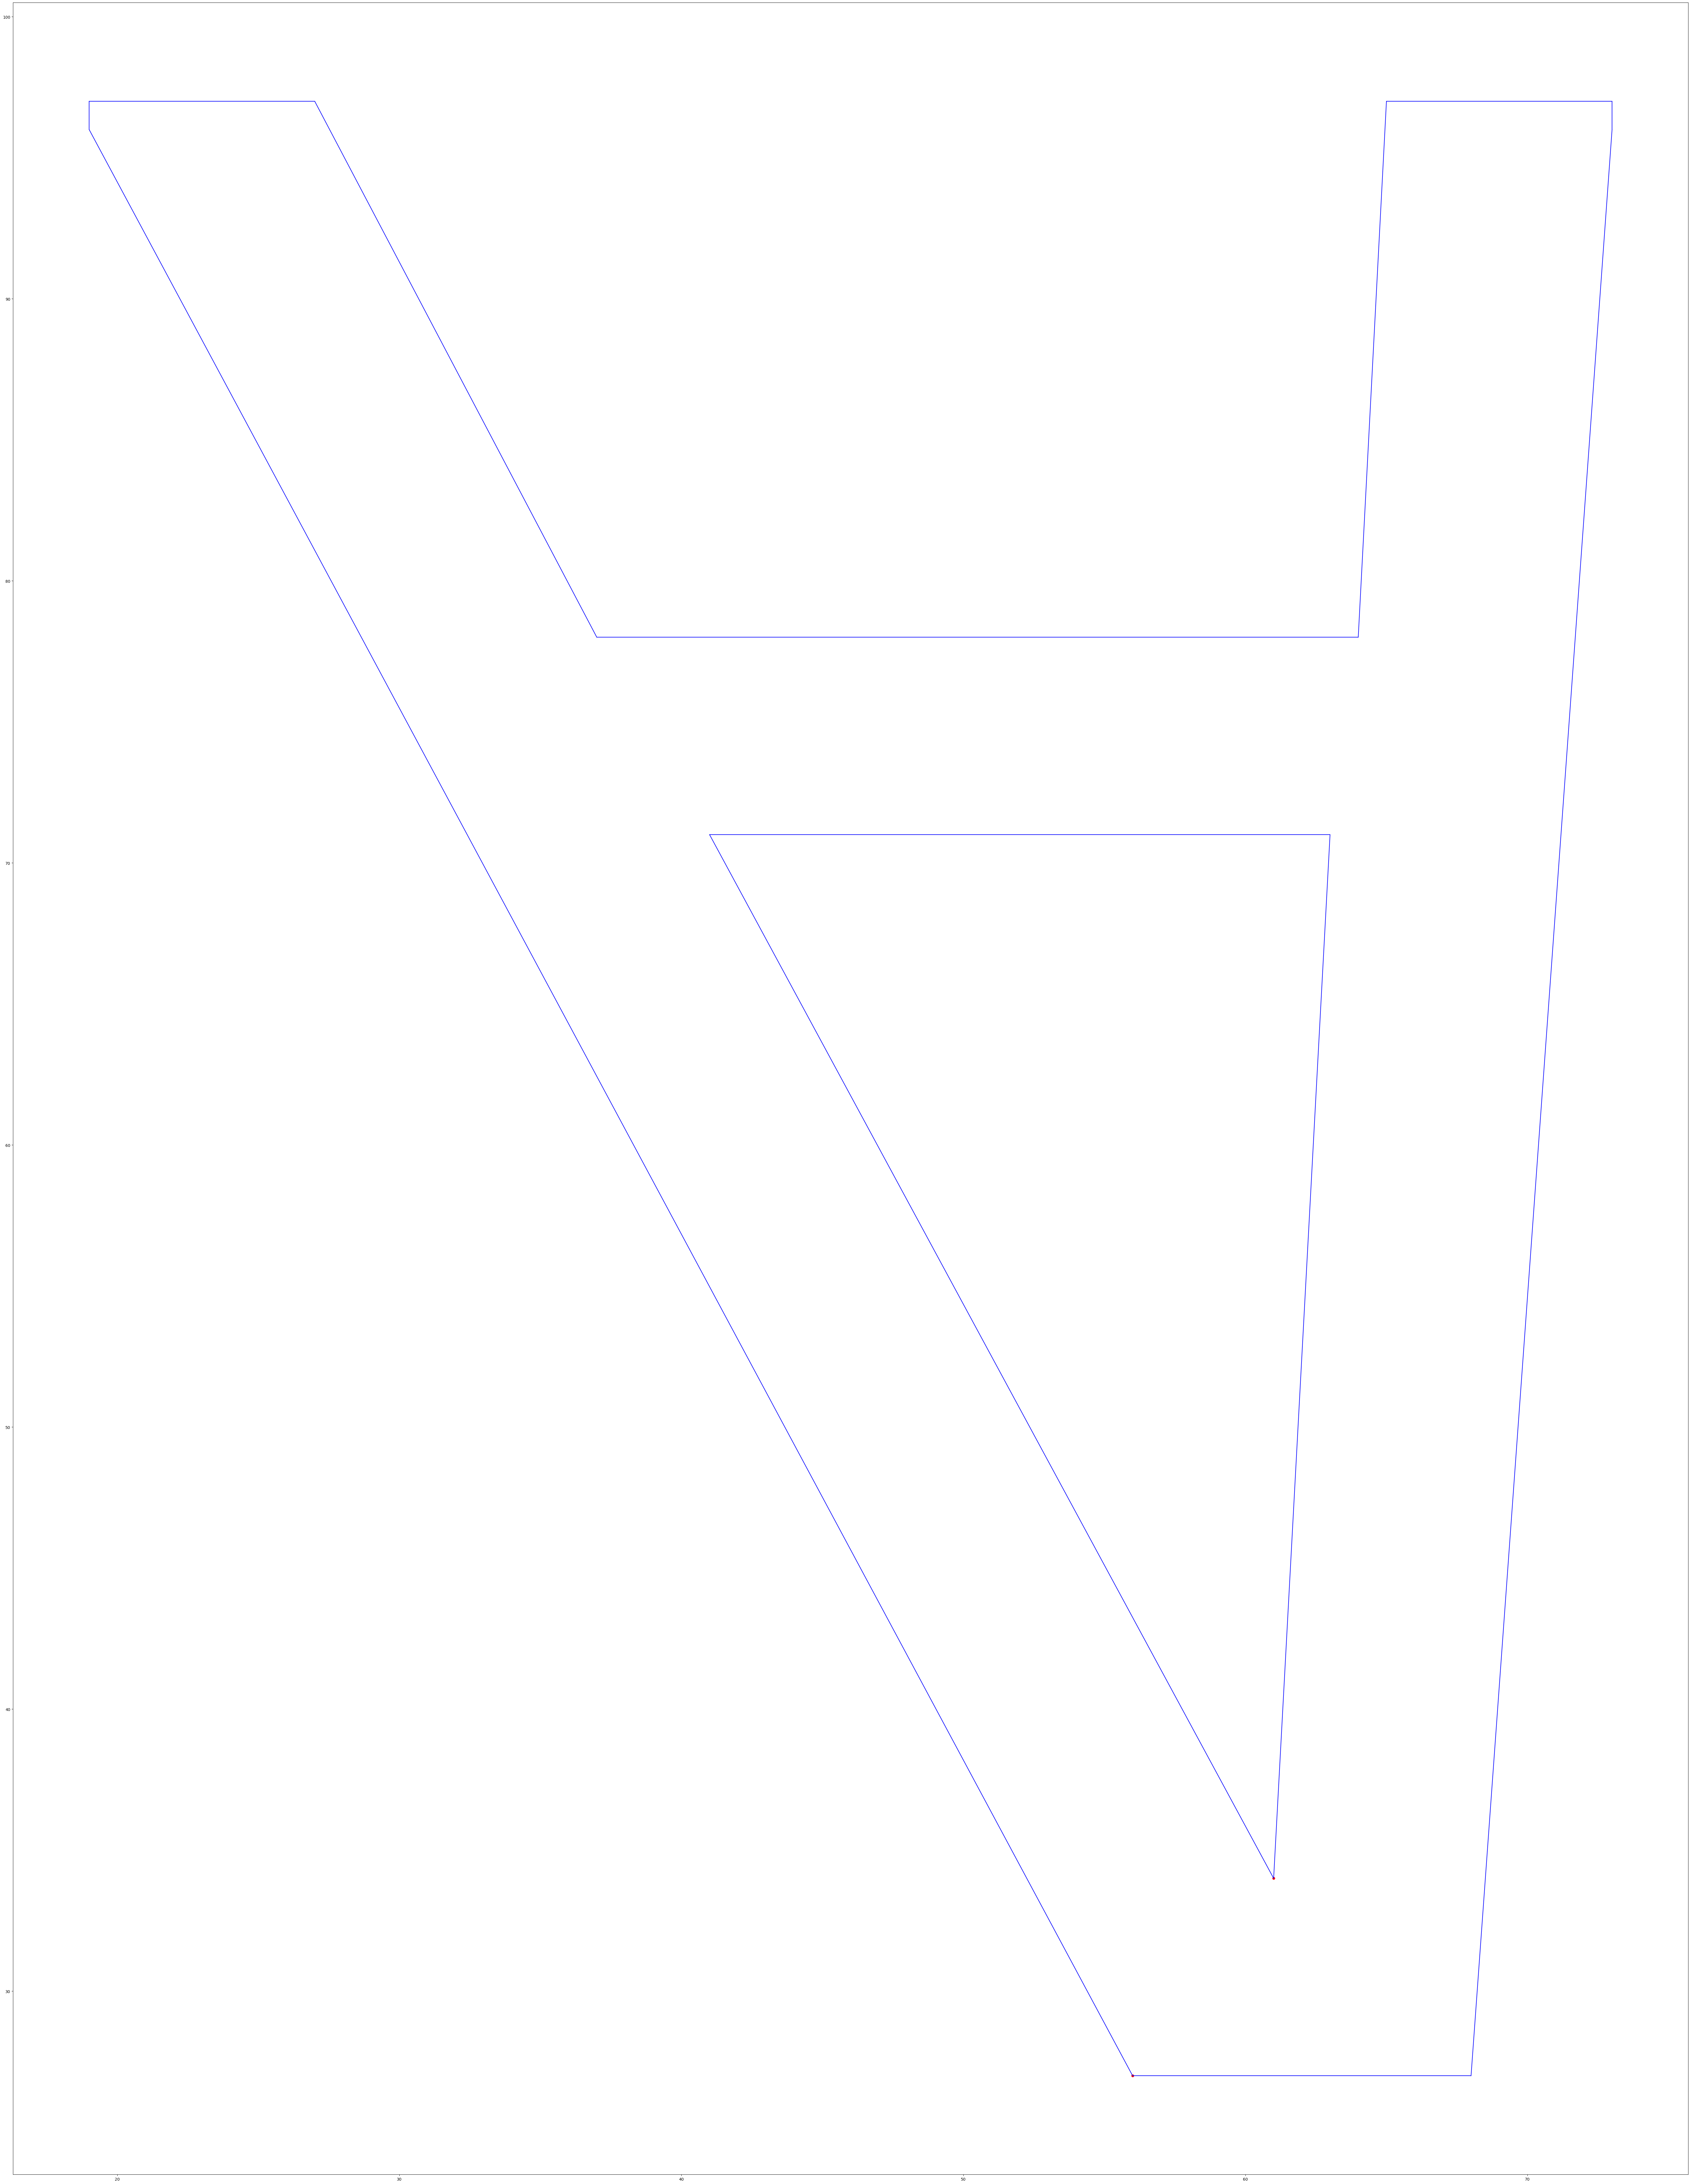

In [173]:
import torch
import matplotlib.pyplot as plt

# Пример тензора
tensor = torch.tensor([[[ 1, 56, 27,  0,  0,  0,  0, 56, 27],
                        [ 2, 56, 27,  0,  0,  0,  0, 68, 27],
                        [ 2, 68, 27,  0,  0,  0,  0, 73, 96],
                        [ 2, 73, 96,  0,  0,  0,  0, 73, 97],
                        [ 2, 73, 97,  0,  0,  0,  0, 65, 97],
                        [ 2, 65, 97,  0,  0,  0,  0, 64, 78],
                        [ 2, 64, 78,  0,  0,  0,  0, 37, 78],
                        [ 2, 37, 78,  0,  0,  0,  0, 27, 97],
                        [ 2, 27, 97,  0,  0,  0,  0, 19, 97],
                        [ 2, 19, 97,  0,  0,  0,  0, 19, 96],
                        [ 2, 19, 96,  0,  0,  0,  0, 56, 27],
                        [ 1, 61, 34,  0,  0,  0,  0, 61, 34],
                        [ 2, 61, 34,  0,  0,  0,  0, 41, 71],
                        [ 2, 41, 71,  0,  0,  0,  0, 63, 71],
                        [ 2, 63, 71,  0,  0,  0,  0, 61, 34],
                        [ 2, 61, 34,  0,  0,  0,  0, 61, 34]]])

# Функция для рисования буквы
def draw_letter(tensor):
    fig, ax = plt.subplots(figsize=(100, 100))

    for command in tensor[0]:
        cmd = command[0].item()
        x0, y0 = command[1].item(), command[2].item()
        x1, y1 = command[3].item(), command[4].item()
        x2, y2 = command[5].item(), command[6].item()
        x3, y3 = command[7].item(), command[8].item()

        if cmd == 1:  # Move command
            ax.plot(x0, y0, 'ro')  # Mark the point with a red dot
        elif cmd == 2:  # Line command
            ax.plot([x0, x3], [y0, y3], 'b-')  # Draw a blue line

    ax.set_aspect('equal')
    plt.show()

# Вызов функции для рисования
draw_letter(tensor)


In [174]:
ad = {"b" : 200, "a" : 100}
print(ad[200])

KeyError: 200